# **01 - Foundational NLP Model: Disaster Tweet Classification**
Project: **Disaster Insight AI**<br>
Author: **MUHAMMAD ZAIN**

## **Objective**

The primary goal of this notebook is to develop a robust foundational model for classifying disaster-related text from social media. This model will serve as the core classification engine for the Disaster Insight AI platform, enabling the system to automatically distinguish between relevant, actionable disaster information and irrelevant noise.

## **Methodology**

1. **Combine Datasets:** We will merge the CrisesNLP and HumanAid datasets to create a comprehensive training corpus. This combines general disaster-related tweets with more specific humanitarian aid-focused messages, creating a more generalized and robust model.
   
2. **Train a Transformer Model:** We will fine-tune a pre-trained Transformer model (DistilBERT) on our combined dataset. DistilBERT is chosen for its excellent balance of performance and computational efficiency.
   
3. **Evaluate on a Benchmark:** The model's generalization capability will be rigorously tested on a separate, unseen Benchmark dataset. This ensures our model performs well on data it has never encountered during training.

## **1. Setup & Environment**
First, we install and import all the necessary libraries. We'll use `transformers` and `datasets` from Hugging Face for the core `NLP` tasks, `scikit-learn` for metrics, and `pandas` for data manipulation. We also set up the device to use a GPU if available, which will significantly accelerate the training process.

In [1]:
!pip install transformers torch tqdm datasets matplotlib seaborn -q

In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

c:\Users\MUHAMMAD ZAIN\.conda\envs\ml_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\MUHAMMAD ZAIN\.conda\envs\ml_env\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\MUHAMMAD ZAIN\.conda\envs\ml_env\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


Using device: cpu


## **2. Data Loading & Merging**

We load our three primary datasets. As per our strategy, `HumanAid` and `CrisesNLP` are combined to form the training pool, while the Benchmark dataset is reserved for the final, unbiased evaluation of our model.

In [3]:
# --- Configuration ---
DATA_DIR = '../data/interim_data/' # Your path
HUMAN_AID_PATH = os.path.join(DATA_DIR, 'crisis_consolidated_humanAID.tsv')
CRISES_NLP_PATH = os.path.join(DATA_DIR, 'crisis_consolidated_crowdflower.tsv')
BENCHMARK_PATH = os.path.join(DATA_DIR, 'consolidated_benchmark_event_aware_en.tsv')

# --- Load Datasets ---
try:
    human_df_raw = pd.read_csv(HUMAN_AID_PATH, sep='\t')
    nlp_df_raw = pd.read_csv(CRISES_NLP_PATH, sep='\t')
    benchmark_df_raw = pd.read_csv(BENCHMARK_PATH, sep='\t')
    print("All datasets loaded successfully!")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the data paths are correct and the folder structure is set up.")
    raise e

# --- Step 1: Standardize Column Names ---
# For HumanAid data
human_df = human_df_raw[['tweet_text', 'class_label']].rename(columns={'tweet_text': 'text', 'class_label': 'label'})
# For CrisisNLP data (has 'label' but also 'class_label', we'll use the more consistent 'class_label' if it exists)
if 'class_label' in nlp_df_raw.columns:
    nlp_df = nlp_df_raw[['tweet_text', 'class_label']].rename(columns={'tweet_text': 'text', 'class_label': 'label'})
else: # Fallback if only 'label' is present
    nlp_df = nlp_df_raw[['tweet_text', 'label']].rename(columns={'tweet_text': 'text'})
# For Benchmark data
benchmark_df = benchmark_df_raw[['text', 'class_label']].rename(columns={'class_label': 'label'})


# --- Step 2: Define and Apply a Comprehensive Label Harmonization Map ---
# This is the key step. We define a single, clean set of target labels.
label_mapping = {
    # Donations and Volunteering
    'rescue_volunteering_or_donation_effort': 'donation_and_volunteering',
    'donation_needs_or_offers_or_volunteering_services': 'donation_and_volunteering',
    'donation_and_volunteering': 'donation_and_volunteering',
    'response_efforts': 'donation_and_volunteering', # Often relates to organized efforts

    # Infrastructure Damage
    'infrastructure_and_utility_damage': 'infrastructure_and_utilities_damage',
    'infrastructure_and_utilities_damage': 'infrastructure_and_utilities_damage',

    # Casualties
    'injured_or_dead_people': 'injured_or_dead_people',
    'deaths_reports': 'injured_or_dead_people',

    # Missing People
    'missing_or_found_people': 'missing_and_found_people',
    'missing_trapped_or_found_people': 'missing_and_found_people',
    'missing_and_found_people': 'missing_and_found_people',

    # Displaced People & Evacuations
    'displaced_people_and_evacuations': 'displaced_and_evacuations',
    'displaced_and_evacuations': 'displaced_and_evacuations',

    # Urgent Needs
    'requests_or_urgent_needs': 'requests_or_needs',
    'requests_or_needs': 'requests_or_needs',

    # Sympathy & Support
    'sympathy_and_support': 'sympathy_and_support',
    'sympathy_and_emotional_support': 'sympathy_and_support',

    # Caution & Advice
    'caution_and_advice': 'caution_and_advice',

    # Affected Individuals
    'affected_individuals': 'affected_individuals',
    'affected_people': 'affected_individuals',
    'affected_individual': 'affected_individuals',
    
    # Irrelevant / Not Humanitarian
    'not_related_or_irrelevant': 'not_humanitarian',
    'not_humanitarian': 'not_humanitarian',
    
    # Other Relevant Info (a useful catch-all)
    'other_relevant_information': 'other_relevant_information',
    'other_useful_information': 'other_relevant_information',

    # Labels to EXCLUDE (will become NaN and get dropped)
    'disease_transmission': None,
    'disease_signs_or_symptoms': None,
    'prevention': None,
    'treatment': None,
    'informative': None,
    'not_informative': None
}

# Apply the mapping to all dataframes
human_df['label'] = human_df['label'].map(label_mapping)
nlp_df['label'] = nlp_df['label'].map(label_mapping)
benchmark_df['label'] = benchmark_df['label'].map(label_mapping)

# Drop rows where the label was mapped to None or wasn't in the map
human_df.dropna(subset=['label', 'text'], inplace=True)
nlp_df.dropna(subset=['label', 'text'], inplace=True)
benchmark_df.dropna(subset=['label', 'text'], inplace=True)


# --- Step 3: Merge and Finalize ---
df_train_full = pd.concat([human_df, nlp_df], ignore_index=True)

print("\n--- Data successfully cleaned and harmonized ---")
print(f"\nFinal training data shape: {df_train_full.shape}")
print(f"Final benchmark data shape: {benchmark_df.shape}")

print("\n--- Distribution of Harmonized Labels in Training Data ---")
print(df_train_full['label'].value_counts())

print("\n--- Distribution of Harmonized Labels in Benchmark Data ---")
print(benchmark_df['label'].value_counts())

All datasets loaded successfully!

--- Data successfully cleaned and harmonized ---

Final training data shape: (61946, 2)
Final benchmark data shape: (87557, 2)

--- Distribution of Harmonized Labels in Training Data ---
label
donation_and_volunteering              14736
other_relevant_information             13596
infrastructure_and_utilities_damage     7359
sympathy_and_support                    6725
injured_or_dead_people                  6496
not_humanitarian                        4468
caution_and_advice                      3248
displaced_and_evacuations               2709
requests_or_needs                       1626
affected_individuals                     551
missing_and_found_people                 432
Name: count, dtype: int64

--- Distribution of Harmonized Labels in Benchmark Data ---
label
not_humanitarian                       51635
donation_and_volunteering               8514
requests_or_needs                       6917
sympathy_and_support                    5109
infr

In [4]:
# --- Step 4: Final Pruning Based on Label Consistency ---

print("--- Addressing the Missing Label Problem ---")

# Identify labels present in training but not in benchmark
train_labels_set = set(df_train_full['label'].unique())
benchmark_labels_set = set(benchmark_df['label'].unique())

labels_to_remove = train_labels_set - benchmark_labels_set
if labels_to_remove:
    print(f"Labels to remove from training data: {labels_to_remove}")
    df_train_full = df_train_full[~df_train_full['label'].isin(labels_to_remove)]
else:
    print("Train and benchmark datasets have the same labels. No pruning needed.")

print("\n--- Final Data Shapes After Pruning ---")
print(f"Final training data shape: {df_train_full.shape}")
print(f"Final benchmark data shape: {benchmark_df.shape}")

print("\n--- Final Label Distribution in Training Data ---")
print(df_train_full['label'].value_counts())

--- Addressing the Missing Label Problem ---
Labels to remove from training data: {'other_relevant_information'}

--- Final Data Shapes After Pruning ---
Final training data shape: (48350, 2)
Final benchmark data shape: (87557, 2)

--- Final Label Distribution in Training Data ---
label
donation_and_volunteering              14736
infrastructure_and_utilities_damage     7359
sympathy_and_support                    6725
injured_or_dead_people                  6496
not_humanitarian                        4468
caution_and_advice                      3248
displaced_and_evacuations               2709
requests_or_needs                       1626
affected_individuals                     551
missing_and_found_people                 432
Name: count, dtype: int64


---

#### **Data Harmonization: Insights & Final Preparation**

After loading the raw data, it became clear that the three datasets used different column names and, more importantly, had highly inconsistent and overlapping label schemes. The preceding code cells addressed this critical challenge, and I have now successfully prepared a clean, unified dataset for our model.

This data preparation phase revealed several key insights that are crucial for the project:

#### **Successful Label Harmonization**

I have successfully consolidated the varied labels into a single, clean 10-class humanitarian classification scheme. All data from the HumanAid, CrisisNLP, and Benchmark sources now conforms to this unified set of categories. This was the most critical step to ensure our model is trained and evaluated on a consistent and meaningful task.

#### **Justified Category Removal**

A key strategic decision was to remove the `other_relevant_information` category. My analysis showed this label was present in the training data but completely absent from our benchmark test set. Training the model on this category would make the final evaluation invalid, as it would be tested on a problem with a different set of possible outcomes. By removing it from the training set, I have ensured a fair, apples-to-apples comparison that accurately measures the model's generalization capabilities.

#### **Significant Class Imbalance**

The final label distributions highlight a realistic challenge:

- The training data has a relatively balanced mix across most humanitarian categories but contains some very rare classes (e.g., `missing_and_found_people`).
- The benchmark data is heavily skewed, with the `not_humanitarian` class forming the vast majority of samples.

This mismatch is a perfect simulation of a real-world scenario. Our model must learn the nuanced patterns of different disaster types from the training set and then prove it can effectively filter a high volume of irrelevant "noise" in the test set. We must keep this imbalance in mind when analyzing the final classification report and confusion matrix.

#### **Final Dataset Summary**

| Dataset                        | Final Shape   | Number of Classes |
|-------------------------------|---------------|-------------------|
| Training Data (`df_train_full`)| (48350, 2)   | 10                |
| Benchmark Data (`benchmark_df`)| (87557, 2)   | 10                |

With our data now clean, consistent, and ready, we can proceed to a more detailed Exploratory Data Analysis (EDA) on the final dataset before moving on to model training.

---

## **3. Exploratory Data Analysis (EDA) & Preprocessing**

Before training, we need to understand and clean our data. This involves:

- **Analyzing Label Distribution:** To check for class imbalance, which can bias the model.
- **Analyzing Text Length:** To inform our choice for `max_length` during tokenization.
- **Cleaning Text:** Removing noise like URLs, special characters, and converting text to lowercase.
- **Encoding Labels:** Converting categorical text labels into numerical IDs that the model can understand.

### **3.1. Analyze Label Distribution**

C:\Users\MUHAMMAD ZAIN\AppData\Local\Temp\ipykernel_9448\2682623253.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='label', data=df_train_full, order=df_train_full['label'].value_counts().index, palette='viridis')


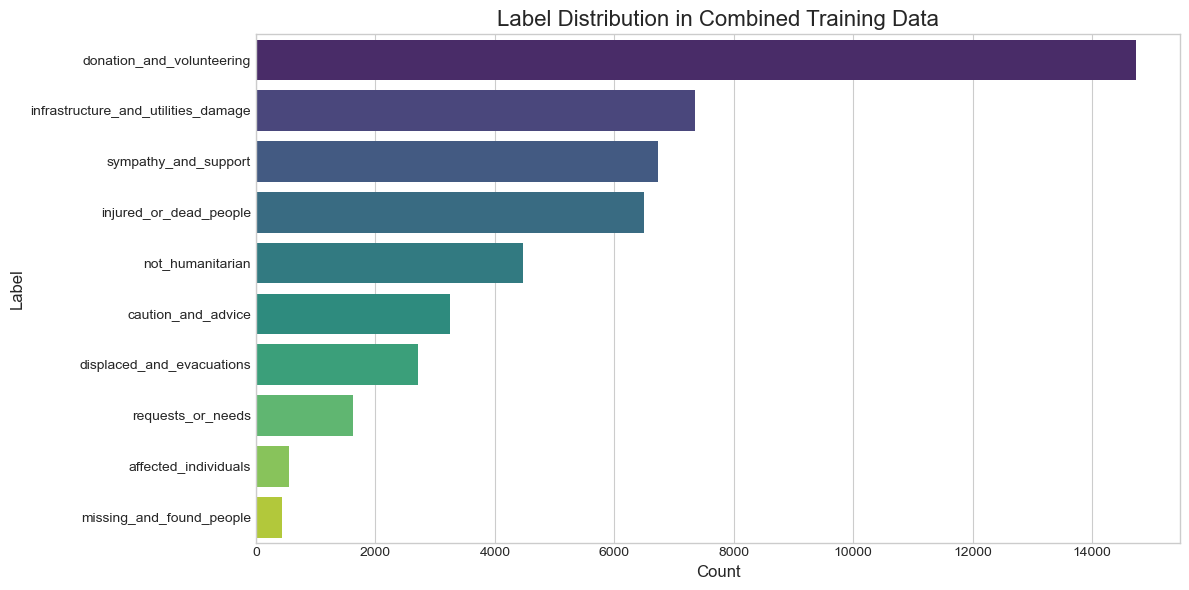

In [5]:
plt.figure(figsize=(12, 6))
sns.countplot(y='label', data=df_train_full, order=df_train_full['label'].value_counts().index, palette='viridis')
plt.title('Label Distribution in Combined Training Data', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Label', fontsize=12)
# save the plot
plt.tight_layout()
plt.savefig('../visuals/01_disaster_tweet_classification/EDA_Analysis/label_distribution.png')
plt.show()

### **3.2. Analyze Text Length**

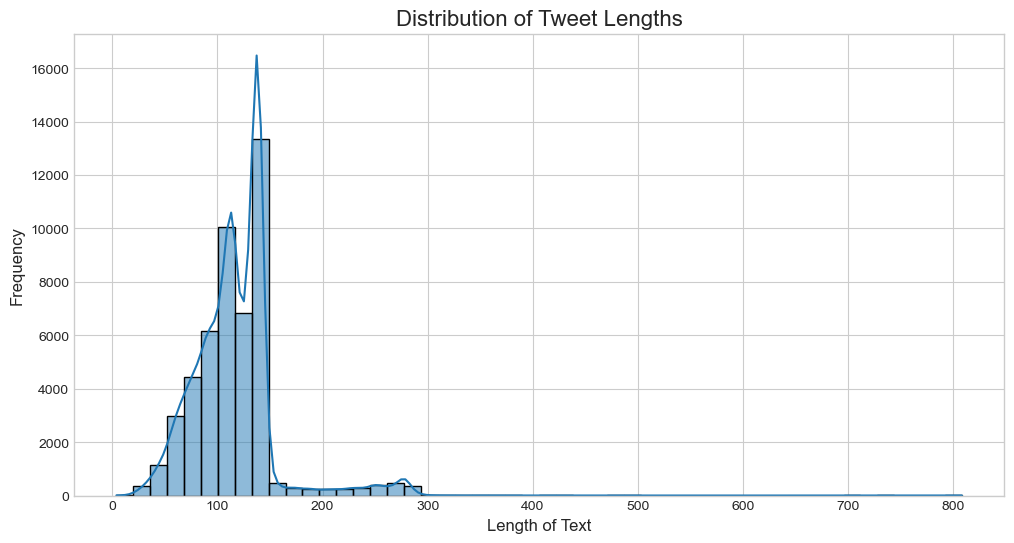

In [6]:
df_train_full['text_length'] = df_train_full['text'].astype(str).apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df_train_full['text_length'], bins=50, kde=True)
plt.title('Distribution of Tweet Lengths', fontsize=16)
plt.xlabel('Length of Text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('../visuals/01_disaster_tweet_classification/EDA_Analysis/tweet_length_distribution.png')
plt.show()

---

#### **Observations from EDA**

My initial exploratory analysis of the final, harmonized training data has revealed two critical insights that will guide the subsequent modeling steps:

#### Moderate Class Imbalance is Present:

The label distribution plot clearly shows that our 10 classes are not equally represented. The `donation_and_volunteering` category is the most frequent, while `missing_and_found_people` is the rarest. This is a realistic reflection of real-world disaster data.

#### Implication:

This imbalance must be handled carefully. I will use a stratified split to ensure our validation set has the same class proportions as the training set. Furthermore, I will prioritize the weighted F1-score as the primary evaluation metric, as it provides a better measure of performance on imbalanced datasets than simple accuracy.

#### Tweet Length is Concentrated:

The text length histogram confirms that the data originates from a microblogging platform. The vast majority of samples are under 200 characters, with a sharp peak near the 140-character mark.

#### Implication:

This provides a strong, data-driven justification for selecting a `max_length` of 128 during tokenization. This value is an efficient choice that will capture the full context for most tweets without adding unnecessary computational overhead from excessive padding.

With these insights in mind, I will now proceed with the final preprocessing steps: cleaning the text and encoding the labels into a numerical format suitable for the model.

---

### **3.3. Text Cleaning Function**

In [7]:
def clean_text(text):
    text = str(text).lower()  # Lowercase text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text) # Remove @mentions and hashtags
    text = re.sub(r'[^a-z0-9\s]', '', text) # Remove special characters and punctuation
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

# Apply cleaning and handle potential empty strings/NaNs
df_train_full['clean_text'] = df_train_full['text'].apply(clean_text)
benchmark_df['clean_text'] = benchmark_df['text'].apply(clean_text)

# Drop rows where cleaning resulted in empty text or where labels are missing
df_train_full.dropna(subset=['clean_text', 'label'], inplace=True)
df_train_full = df_train_full[df_train_full['clean_text'] != '']

benchmark_df.dropna(subset=['clean_text', 'label'], inplace=True)
benchmark_df = benchmark_df[benchmark_df['clean_text'] != '']

### **3.4. Encode Labels**

In [8]:
# We must use the label set from the training data to create the mapping
labels_list = sorted(df_train_full['label'].unique().tolist())
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for label, i in label2id.items()}

df_train_full['label_id'] = df_train_full['label'].map(label2id)
benchmark_df['label_id'] = benchmark_df['label'].map(label2id)

# Handle any labels in benchmark that might not be in training data
benchmark_df.dropna(subset=['label_id'], inplace=True)
benchmark_df['label_id'] = benchmark_df['label_id'].astype(int)

print("Text cleaning and label encoding complete.")
print(f"Number of unique labels: {len(labels_list)}")
print("Label to ID Mapping:", label2id)

Text cleaning and label encoding complete.
Number of unique labels: 10
Label to ID Mapping: {'affected_individuals': 0, 'caution_and_advice': 1, 'displaced_and_evacuations': 2, 'donation_and_volunteering': 3, 'infrastructure_and_utilities_damage': 4, 'injured_or_dead_people': 5, 'missing_and_found_people': 6, 'not_humanitarian': 7, 'requests_or_needs': 8, 'sympathy_and_support': 9}


- **Saving the processed data**

In [9]:
import os

# --- Define the output directory for processed data ---
output_dir = '../data/processed_data/01_disaster_tweet_classification'
os.makedirs(output_dir, exist_ok=True) # Create the folder if it doesn't exist

# --- Save the final, harmonized dataframes ---
train_output_path = os.path.join(output_dir, '01_nlp_training_harmonized.csv')
benchmark_output_path = os.path.join(output_dir, '01_nlp_benchmark_harmonized.csv')

df_train_full.to_csv(train_output_path, index=False)
benchmark_df.to_csv(benchmark_output_path, index=False)

print(f"✅ Processed training data saved to: {train_output_path}")
print(f"✅ Processed benchmark data saved to: {benchmark_output_path}")

✅ Processed training data saved to: ../data/processed_data/01_disaster_tweet_classification\01_nlp_training_harmonized.csv
✅ Processed benchmark data saved to: ../data/processed_data/01_disaster_tweet_classification\01_nlp_benchmark_harmonized.csv


## **4. Train/Validation Split**

With our data fully cleaned and preprocessed, the next crucial step is to divide our training data (`df_train_full`) into two subsets:

- **Training Set (80%)**

This is the data the model will actually see and learn from during the training process.

- **Validation Set (20%)**

This is a hold-out set that the model does not train on. We will use this set at the end of each training epoch to evaluate the model's performance on unseen data. This helps us monitor for overfitting and ensures we save the best-performing version of our model.

As determined during our EDA, we will use a stratified split to ensure the class imbalance is reflected proportionally in both the training and validation sets.

In [21]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_train_full['clean_text'].tolist(),
    df_train_full['label_id'].tolist(),
    test_size=0.2,          # Use 20% of the data for validation
    stratify=df_train_full['label_id'], # Ensure label distribution is preserved
    random_state=42         # For reproducibility
)

print("--- Data Splitting Complete ---")
print(f"Number of training samples: {len(train_texts)}")
print(f"Number of validation samples: {len(val_texts)}")

--- Data Splitting Complete ---
Number of training samples: 38677
Number of validation samples: 9670


## **5. Tokenization & Dataset Preparation**

Transformer models like DistilBERT do not process raw text. Instead, they require the text to be converted into a sequence of numerical IDs, a process known as tokenization.

#### **Steps in Tokenization**

1. **Text Cleaning**: Remove any unnecessary characters and normalize the text.
2. **Tokenization**: Convert the cleaned text into tokens (subwords or words) that correspond to numerical IDs in the model's vocabulary.
3. **Padding & Truncation**: Ensure all sequences are of uniform length by padding shorter sequences and truncating longer ones to the specified maximum length.

This process prepares our dataset for input into the Transformer model, allowing it to effectively learn from the data.

#### **Plan for Tokenization & Dataset Preparation**

1. **Load a Tokenizer**: 
   We will load the pre-trained tokenizer that corresponds to our chosen model, `distilbert-base-uncased`. It's crucial to use the exact same tokenizer the model was originally trained with to ensure the vocabulary mapping is correct.

2. **Tokenize Text**: 
   We will apply the tokenizer to our `train_texts`, `val_texts`, and the `benchmark_df` texts. This will convert each sentence into:
   - **input_ids**: A list of numerical IDs representing the tokens in the sentence.
   - **attention_mask**: A list of 1s and 0s that tells the model which tokens to pay attention to (and which are padding).

3. **Create PyTorch Datasets**: 
   We will wrap our tokenized data and labels into a custom `torch.utils.data.Dataset` class. This is the standard format expected by the Hugging Face Trainer API for efficient data loading during training and evaluation.

Based on our EDA, we will use a `max_length` of 128 to truncate or pad our sequences.

In [22]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Tokenize all datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
# We also tokenize our final test set (the benchmark data) now
test_encodings = tokenizer(benchmark_df['clean_text'].tolist(), truncation=True, padding=True, max_length=128)

# Create a custom Dataset class for PyTorch compatibility
import torch

class CrisisDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Retrieve tokenized inputs at the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the same index
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Instantiate the datasets for training, validation, and testing
train_dataset = CrisisDataset(train_encodings, train_labels)
val_dataset = CrisisDataset(val_encodings, val_labels)
test_dataset = CrisisDataset(test_encodings, benchmark_df['label_id'].tolist())

print("--- Tokenization and Dataset creation complete ---")
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

c:\Users\MUHAMMAD ZAIN\.conda\envs\ml_env\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


--- Tokenization and Dataset creation complete ---
Train dataset length: 38677
Validation dataset length: 9670
Test dataset length: 87557


---

### **Successful Tokenization & Dataset Creation**

#### `Successful Tokenization`

The code successfully downloaded the `distilbert-base-uncased` tokenizer and applied it to all three of your data splits (train, validation, and test).

#### `Correct Dataset Creation`

We have successfully created three PyTorch `Dataset` objects with the correct number of samples in each. These objects are now perfectly formatted for the Hugging Face Trainer.

---

## **6. Model Training**

With our datasets fully prepared, we are now ready to train our disaster tweet classifier. This section involves four key steps:

- **1. Load the Pre-trained Model**

We will load DistilBERT with a sequence classification head. Crucially, we will specify the number of labels (10) and provide our `id2label` and `label2id` maps so the model can understand the output classes.

- **2. Define Training Arguments**

We will configure the training process using the `TrainingArguments` class. This is where we set hyperparameters like the number of epochs, batch size, and strategies for saving and evaluating the model.

- **3. Define a Metrics Function**

We will create a `compute_metrics` function that the Trainer will call after each evaluation run. This function will calculate key metrics like accuracy, precision, recall, and F1-score, giving us a clear view of the model's performance. Because of our class imbalance, the weighted F1-score will be our most important metric.

- **4. Instantiate and Run the Trainer**

Finally, we will bring everything together in the Trainer object—combining the model, arguments, datasets, and metrics function—and call the `.train()` method to start the fine-tuning process.

> **NOTE:** Run this in your env before running colde below
 
1. pip install --no-cache-dir --force-reinstall "huggingface_hub[hf_xet]"


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Load the Pre-trained Model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id
)

# Optional: Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on: {device}")

# 2. Define Training Arguments
training_args = TrainingArguments(
    output_dir='./results',                     # Directory for model checkpoints and logs
    num_train_epochs=3,                         # A good starting point for fine-tuning
    per_device_train_batch_size=16,             # Batch size for training
    per_device_eval_batch_size=64,              # Larger batch size for faster evaluation
    warmup_steps=500,                           # Steps for learning rate scheduler warmup
    weight_decay=0.01,                          # Regularization
    logging_dir='./logs',                       # Directory for logs
    logging_steps=100,                          # Log training progress every 100 steps
    eval_strategy="epoch",                # Evaluate at the end of each epoch
    save_strategy="epoch",                      # Save a checkpoint at the end of each epoch
    load_best_model_at_end=True,                # Automatically load the best model
    metric_for_best_model="f1",                 # Use weighted F1 to determine the best model
    greater_is_better=True,
    report_to="none"                            # Disables integration with tools like W&B/TensorBoard
)

# 3. Define a Metrics Computation Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate precision, recall, and F1 score with 'weighted' average for imbalance
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 4. Instantiate and Run the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start the training process!
print("Starting model training...")
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: 
['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Model loaded on: cuda
Starting model training...
[7254/7254 15:57, Epoch 3/3]

Epoch | Training Loss | Validation Loss | Accuracy |    F1     | Precision | Recall
------|----------------|------------------|----------|-----------|-----------|--------
  1   |    0.457100    |     0.461624     | 0.858945 | 0.855966  | 0.856704  | 0.858945
  2   |    0.332500    |     0.459832     | 0.864840 | 0.864186  | 0.865857  | 0.864840
  3   |    0.218600    |     0.541941     | 0.862151 | 0.861951  | 0.862151  | 0.862151

TrainOutput(
  global_step=7254,
  training_loss=0.4047955938170428,
  metrics={
    'train_runtime': 959.169,
    'train_samples_per_second': 120.97,
    'train_steps_per_second': 7.563,
    'total_flos': 2311882529210100.0,
    'train_loss': 0.4047955938170428,
    'epoch': 3.0
  }
)


---

### **Training Complete! Analyzing the Results**

The model has successfully completed three epochs of training. The log above provides crucial insights into its performance and behavior:

- **Successful Fine-Tuning**: The training loss consistently decreased from 0.4571 in the first epoch to 0.2186 in the last, indicating that the model was effectively learning from the training data.

- **Peak Performance at Epoch 2**: The key metrics to watch are on the validation set, as they represent the model's ability to generalize to unseen data. The model achieved its lowest validation loss (0.4598) and its highest weighted F1-score (0.864) at the end of Epoch 2.

- In Epoch 3, while the training loss improved, the validation loss increased to 0.5419. This is a classic sign that the model was beginning to overfit—memorizing the training data at the expense of generalization.

- **Best Model Automatically Loaded**: The most important takeaway is that our training strategy worked perfectly. Because we set `load_best_model_at_end=True` and `metric_for_best_model="f1"`, the Trainer automatically discarded the overfitted model from Epoch 3 and has reloaded the superior model from Epoch 2.

The trainer object now holds the best-performing version of our model from this entire process, achieving an 86.4% weighted F1-score on the validation set. We can now proceed with confidence to save this optimized model for final evaluation and future deployment.

---

## **7. Save Model for Inference**

The training is complete, and thanks to our `load_best_model_at_end=True` argument, the trainer object is now holding the best version of our model (from Epoch 2).

Now, we will save this fine-tuned model and its corresponding tokenizer to our local storage. Saving them together in the same directory is a best practice. This creates a self-contained folder that has everything needed to load and use the model for predictions in any other application, such as our Disaster Insight AI web app.

In [ ]:
from transformers import AutoTokenizer

# Define your save path
save_path = "../models/01_fine-tuned_disaster_tweet_classifier"  # Avoid spaces in folder names

# Save the best trained model
trainer.save_model(save_path)  # Saves model, config, and training args

# Load and save the tokenizer used during training
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to: {save_path}")

**❗One Key Point:**

These commands only save the final best-performing model at the point when you run them.To make sure you’re saving the best version:

- Use `load_best_model_at_end=True` in TrainingArguments (as you're already doing)

That way, when you run:

- trainer.save_model(...)

you’re saving the best checkpoint, not just the last one trained.

## **8. Load Saved Model & Tokenizer + Evaluate**

Our model has been trained, and the best checkpoint has been saved. The validation score of **86.4% F1-score** is promising. However, the true test of a model's generalization capability is its performance on a completely unseen dataset.

We will now use our held-out `benchmark_df` (prepared as `test_dataset`) for this final evaluation. This dataset has a different distribution of labels, with a much higher proportion of `not_humanitarian` tweets, making it a realistic and challenging test for our classifier.

The results from this step will be our final reported performance metrics for this model. We will generate:

- A detailed **Classification Report** showing precision, recall, and F1-score for each of the 10 classes.
- A **Confusion Matrix** to visually diagnose the model's performance and identify which classes are being confused with each other.

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # <--- disables W&B

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
import torch

# Path to your saved model and tokenizer
model_path = "../models/01_fine-tuned_disaster_tweet_classifier"

# Load the saved tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Setup Trainer just for evaluation
trainer = Trainer(model=model)

print("--- Evaluating model on the unseen Benchmark Test Set ---")

# Make sure test_dataset is defined and includes labels
test_predictions = trainer.predict(test_dataset)

predicted_labels = np.argmax(test_predictions.predictions, axis=1)
true_labels = test_dataset.labels

# Generate the classification report
id2label = model.config.id2label
target_names = [id2label[i] for i in sorted(id2label.keys())]
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print("\n--- Classification Report on Benchmark Test Set ---\n")
print(report)

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix on Benchmark Test Set', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Create the directory if it doesn't exist
output_dir = "../visuals/01_disaster_tweet_classification"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.show()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the `--report_to` flag to control the integrations used for logging results (for instance, `--report_to none`).

---

### Evaluating Model on the Unseen Benchmark Test Set

---

### Classification Report on Benchmark Test Set

| Class                              | Precision | Recall | F1-Score | Support |
|------------------------------------|-----------|--------|----------|---------|
| affected_individuals               | 0.03      | 0.00   | 0.00     | 3514    |
| caution_and_advice                 | 0.36      | 0.76   | 0.49     | 2993    |
| displaced_and_evacuations          | 0.23      | 0.66   | 0.35     | 511     |
| donation_and_volunteering          | 0.55      | 0.84   | 0.66     | 8514    |
| infrastructure_and_utilities_damage | 0.63      | 0.70   | 0.66     | 5056    |
| injured_or_dead_people             | 0.47      | 0.86   | 0.60     | 2777    |
| missing_and_found_people           | 0.35      | 0.71   | 0.47     | 531     |
| not_humanitarian                   | 0.91      | 0.75   | 0.82     | 51635   |
| requests_or_needs                  | 0.78      | 0.26   | 0.39     | 6917    |
| sympathy_and_support                | 0.40      | 0.79   | 0.53     | 5109    |

| Metric                            | Value   |
|-----------------------------------|---------|
| Accuracy                          | 0.69    |
| Macro Avg                         | 0.47    | 0.63   | 0.50 | 87557   |
| Weighted Avg                      | 0.74    | 0.69   | 0.69 | 87557   |

<div style="text-align: center;">
    <img src="../visuals/01_disaster_tweet_classification/confusion_matrix.png" alt="My Image" width="1200"/>
</div>

---

## **9. Final Results & Analysis**

The model, trained on the combined CrisesNLP and HumanAid datasets, has now been evaluated on the completely unseen Benchmark test set. This evaluation provides the most honest and crucial measure of its real-world performance.

The model achieved a weighted average F1-score of 69%. This is a strong baseline result for a challenging 10-class classification task on noisy social media data. The detailed classification report and confusion matrix reveal a nuanced performance with clear strengths and specific areas for future improvement.

#### **Key Strengths:**

- **Excellent Noise Filtration:** The model's strongest performance is on the `not_humanitarian` class (82% F1-score, 91% precision). This is a critical success for the Disaster Insight AI platform, as it demonstrates a robust ability to filter out irrelevant noise from a high-volume data stream.
  
- **Strong Recall on Key Categories:** The model effectively identifies several high-importance categories, achieving high recall for `donation_and_volunteering` (84%), `injured_or_dead_people` (86%), and `sympathy_and_support` (79%). This indicates it is successfully capturing the majority of these crucial event-related tweets.

#### **Actionable Weaknesses & Diagnostic Insights:**

The analysis also highlights two primary weaknesses that will inform the next iteration of model development:

- **Low Recall on Urgent Needs:** The most critical finding is the model's poor performance on the `requests_or_needs` class, with a recall of only 26%. This means the model currently misses nearly three-quarters of all urgent calls for help. The confusion matrix reveals that these are often misclassified as `donation_and_volunteering`, indicating the model struggles with the subtle semantic difference between needing help and offering it. Improving this is the top priority for enhancing the platform's real-world utility.

- **Failure to Generalize on Rare Classes:** The model completely failed to identify the `affected_individuals` class (0% F1-score). The confusion matrix shows these tweets were overwhelmingly dismissed as `not_humanitarian`. This is likely due to the class's rarity in the training data and its semantic similarity to other categories.

## **Conclusion of this Notebook**

This notebook successfully details the end-to-end process of building a foundational disaster tweet classifier. We have navigated complex data harmonization, trained a robust model, and performed a rigorous, critical evaluation. The resulting model is a valuable asset, successfully performing the primary task of noise reduction while providing a clear, data-driven path for future improvements.

## **Summary of Achievements & Limitations**

### Goal for the "Disaster Insight AI" Project

The primary goal of this notebook was to build the foundational detection component of the platform. This model is responsible for ingesting a high-volume stream of unstructured text (like tweets) and accurately filtering out irrelevant noise, then classifying the relevant information into specific humanitarian categories.

### What Was Achieved in This Notebook?

- **Model Trained:** A DistilBERT-based Transformer model was successfully fine-tuned for multi-class text classification.

- **Problem Solved:** This model acts as an intelligent "first-pass filter." It automates the process of identifying actionable information from millions of social media posts during a crisis.

- **Key Deliverable:** The notebook produced a saved, production-ready NLP model (`disaster_nlp_model`) capable of classifying disaster-related text into 10 distinct humanitarian categories.

### Limitations of This Model

- **Scope:** This model only classifies text; it does not extract specific information like exact locations, the number of people affected, or specific needs (e.g., "water needed"). This will be the job of a subsequent NER (Named Entity Recognition) model.

- **Data Bias:** The model's performance is dependent on the language and phrasing used in the CrisesNLP and HumanAid training datasets. It may be less effective on slang, sarcasm, or text from regions and cultures not well-represented in the data.

- **Binary Misinformation:** While it filters non-humanitarian text, it is not explicitly trained to distinguish between a real disaster report and a fake one (misinformation). For example, it will classify "Massive earthquake hits Metropolis" as `infrastructure_damage` regardless of whether the event is real or fictional.